# DLProfile Example using Imagenet Application

## Set imports and neccessary environment variables

In [1]:
import pathlib
import os
import sys
import matplotlib.pyplot as plt
import warnings
import pprint
import pandas as pd
import tensorflow as tf
import ntpath
import numpy as np
import math

In [2]:
VANIDL_DIR="{}".format(pathlib.Path(os.getcwd()).parent.parent.parent.absolute())
sys.path.insert(0, VANIDL_DIR)
warnings.filterwarnings('ignore')

In [3]:
os.environ["DARSHAN_DIR"] = "/soft/perftools/darshan/darshan-3.1.8"
os.environ["VANIDL_DIR"] = VANIDL_DIR

### Formatting

In [4]:
pp = pprint.PrettyPrinter(indent=1)
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

## Create instrance of DL Profile and load the darshan file

In [5]:
from src.vanidl import VaniDL
profile = VaniDL()

In [6]:
import shutil
shutil.rmtree('/tmp/temp_analysis')

In [7]:
DATAPATH_INCLUDES = []
status = profile.Load("/home/dhari/darshan-logs/apps/imagenet/imagenet_run1_n128.darshan", data_paths_include=DATAPATH_INCLUDES)
if status:
    print("Darshan Trace loaded Successfully!")
else:
    print("Darshan Trace load Failed!")
    print(profile._error_str())

[============================================================] 100.0% 16219592 of 16219592 Parsing DXT File 
[============================================================] 100.0% 1159308 of 1159308 Parsing Darshan File 
Darshan Trace loaded Successfully!


## Use Profile object to analyze the darshan I/O trace.

### Verify if object works

The GetDXTAsDF() function enables users to perform analysis 

In [8]:
pd.set_option('display.max_colwidth', -1)
df = profile.GetDXTAsDF()
pp.pprint("Number of Files used in the application: {} files".format(df['Filename'].nunique()))

'Number of Files used in the application: 984 files'


### Collect the summary of the Application

In [9]:
summary = profile.GetSummary()
print("\n")
print(color.BOLD + "Data Access Summary (from Darshan):"+ color.END)
print("Total Job time\t\t\t:\t{:0.2f} seconds".format(summary['job_time']))
#FIXME: calculate time per rank and then take max across it.
print("Time spent in I/O\t\t:\t{:0.2f} seconds".format(summary['total_io_time']))
print("% Time spent in I/O\t\t:\t{:0.2f}%".format(float(summary['total_io_time'])*100/summary['job_time']))
print("Total Data Accessed\t\t:\t{:0.2f} GB".format(float(summary['total_io_bytes'])/1024.0/1024.0/1024.0))
print("Data Access Modules used\t:\t{}".format(summary['io_interface_used']))
print("Data Operations\t\t\t:\t{}".format(summary['io_operations_used']))
print("# of files used\t\t\t:\t{}".format(len(summary['files_used'])))
print("# of MPI Ranks\t\t\t:\t{:0.0f} ranks".format(summary['num_ranks']))
      
print(color.UNDERLINE + "Data Transfer size:"+ color.END)
print("\tMin,Max\t\t\t:\t{:0.0f} bytes and {:0.0f} bytes".format(summary['data_transfer_size']['min'],summary['data_transfer_size']['max']))
print("\tAverage\t\t\t:\t{:0.0f} bytes".format(summary['data_transfer_size']['mean']))
print("\tMedian\t\t\t:\t{:0.0f} bytes".format(summary['data_transfer_size']['median']))
      
print(color.UNDERLINE + "Data Transfer bandwidth: (per rank)"+ color.END)
print("\tMin,Max\t\t\t:\t{:0.0f} B/s and {:0.0f} MB/s".format(summary['data_transfer_bandwidth']['min'],summary['data_transfer_bandwidth']['max']/1024.0/1024.0))
print("\tAverage\t\t\t:\t{:0.0f} MB/s".format(summary['data_transfer_bandwidth']['mean']/1024.0/1024.0))
print("\tMedian\t\t\t:\t{:0.0f} MB/s".format(summary['data_transfer_bandwidth']['median']/1024.0/1024.0))
      
print(color.UNDERLINE + "Access Pattern:"+ color.END)
print("\tSequential\t\t:\t{:0.2f}%".format(float(summary['access_pattern']['sequential'])))
print("\tConsecutive\t\t:\t{:0.2f}%".format(float(summary['access_pattern']['consecutive'])))
#An I/O op issued at an offset greater than where the previous I/O op ended.
#An I/O op issued at the offset immediately after the end of the previous I/O

print("\n")
print(color.BOLD + "Files Summary:"+ color.END)
print("File Types\t\t\t:\t{}".format("tfrecord"))
print(color.UNDERLINE + "Dataset Size:"+ color.END)
print("\tTotal\t\t\t:\t{:0.3f} GB".format(float(summary['file_used_summary']['size']['total'])/1024.0/1024.0/1024.0))
print("\tMin,Max\t\t\t:\t{:0.3f} GB and {:0.3f} GB".format(float(summary['file_used_summary']['size']['min'])/1024.0/1024.0/1024.0,float(summary['file_used_summary']['size']['max'])/1024.0/1024.0/1024.0))
print("\tAverage\t\t\t:\t{:0.3f} GB".format(float(summary['file_used_summary']['size']['mean'])/1024.0/1024.0/1024.0))



Data Access Summary (from Darshan):
Total Job time			:	3451.00 seconds
Time spent in I/O		:	169.38 seconds
% Time spent in I/O		:	4.91%
Total Data Accessed		:	3864.95 GB
Data Access Modules used	:	['X_POSIX']
Data Operations			:	['read']
# of files used			:	984
# of MPI Ranks			:	512 ranks
Data Transfer size:
	Min,Max			:	0 bytes and 262144 bytes
	Average			:	261086 bytes
	Median			:	262144 bytes
Data Transfer bandwidth: (per rank)
	Min,Max			:	0 B/s and 2500 MB/s
	Average			:	818 MB/s
	Median			:	833 MB/s
Access Pattern:
	Sequential		:	99.74%
	Consecutive		:	99.74%


Files Summary:
File Types			:	tfrecord
Dataset Size:
	Total			:	133.937 GB
	Min,Max			:	0.000 GB and 0.151 GB
	Average			:	0.116 GB


In [10]:
pp.pprint("Job time : {} seconds".format(profile.GetJobTime()))

'Job time : 3451.0 seconds'


In [11]:
pp.pprint("Time spent by application on I/O: {} seconds".format(profile.GetIOTime()))

'Time spent by application on I/O: 169.3750995978084 seconds'


### I/O time spent on each file

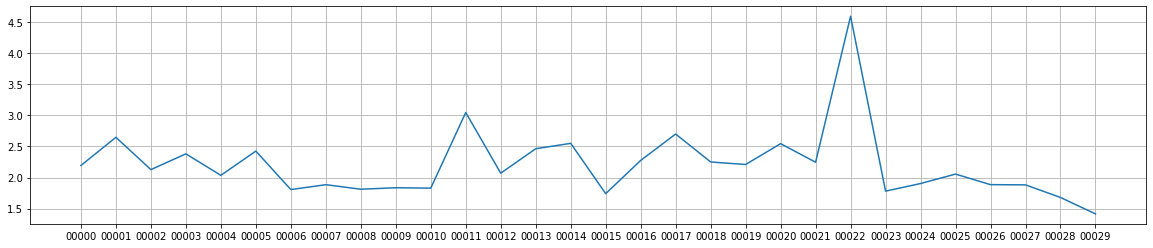

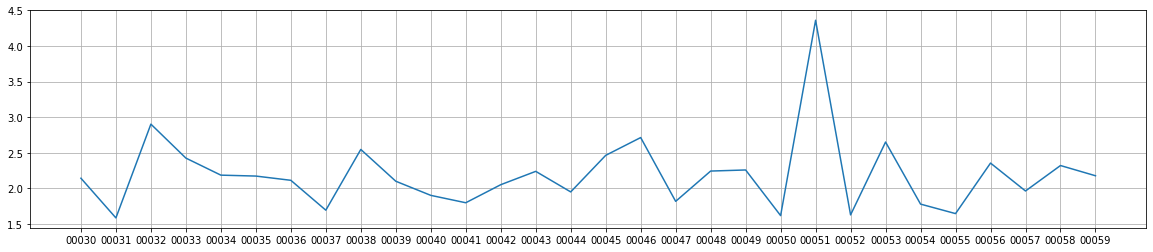

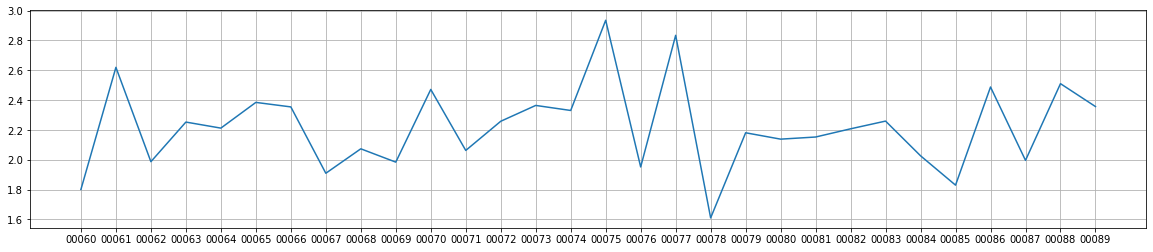

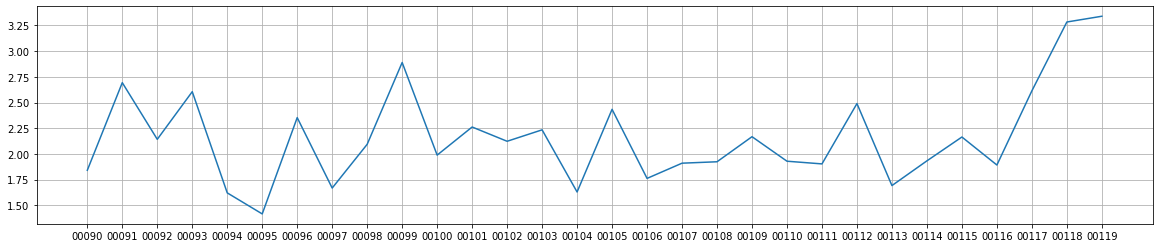

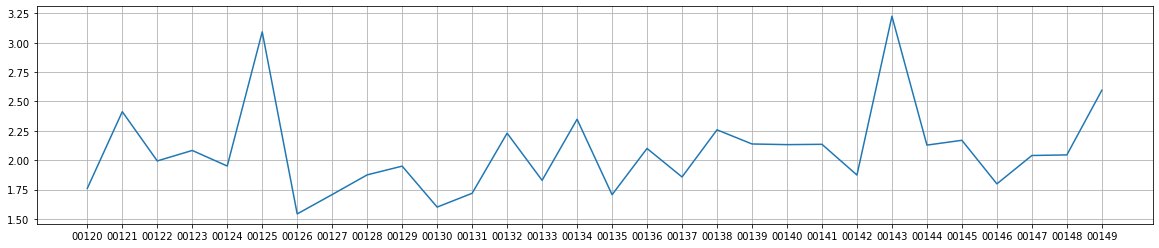

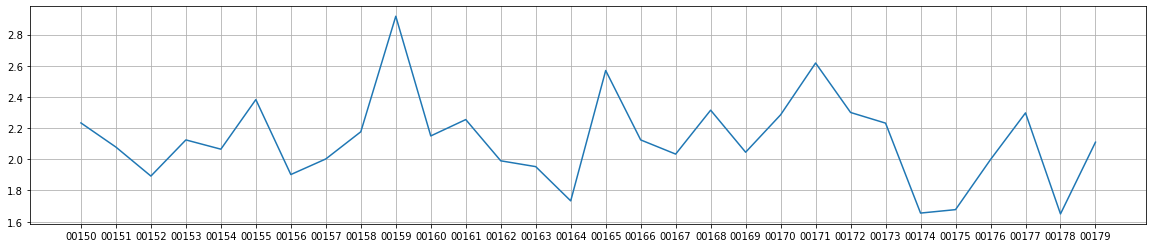

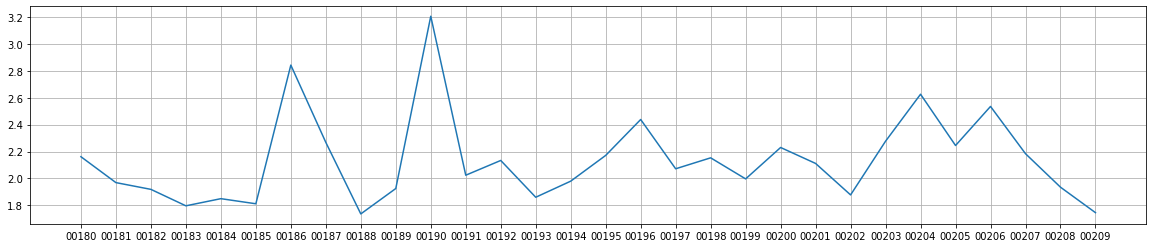

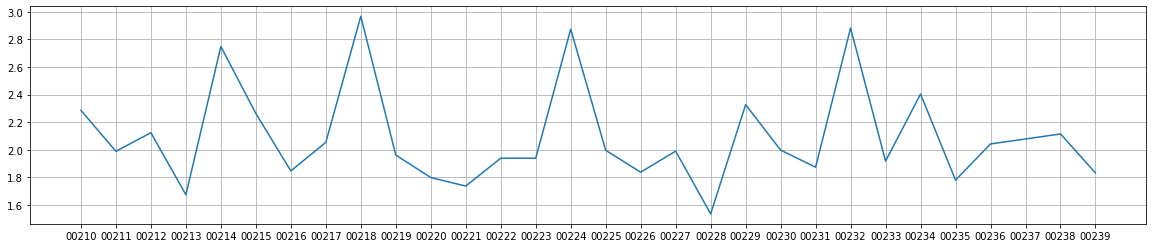

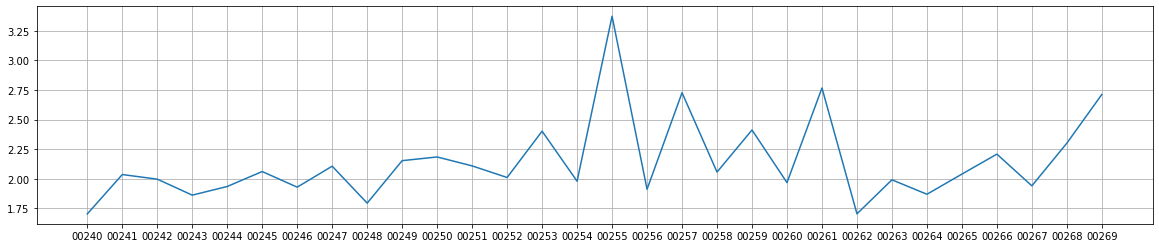

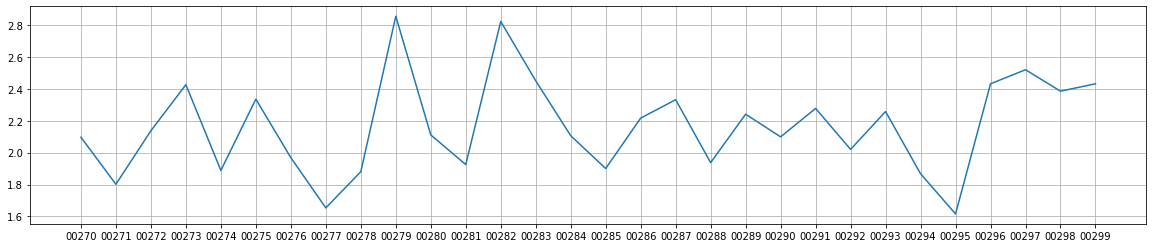

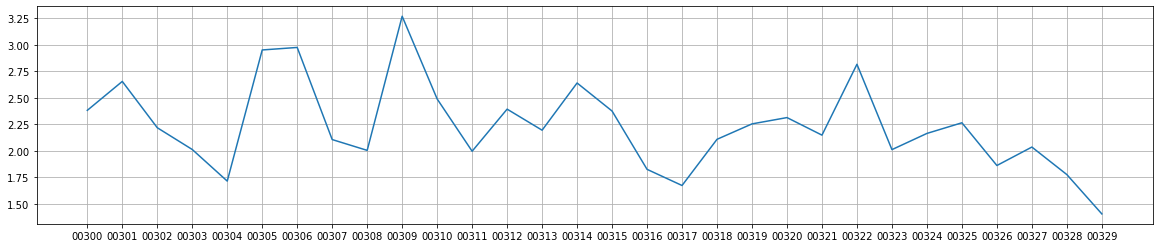

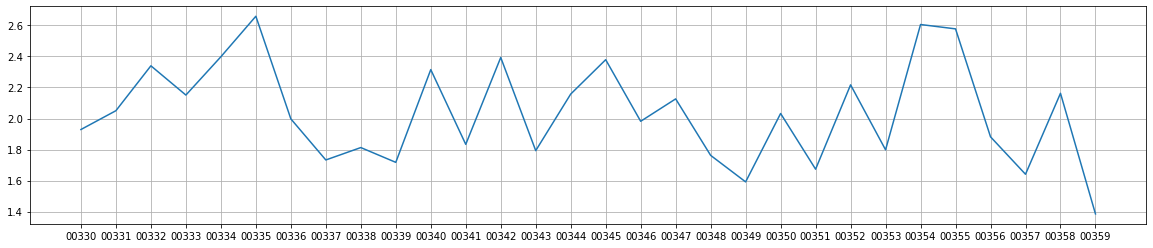

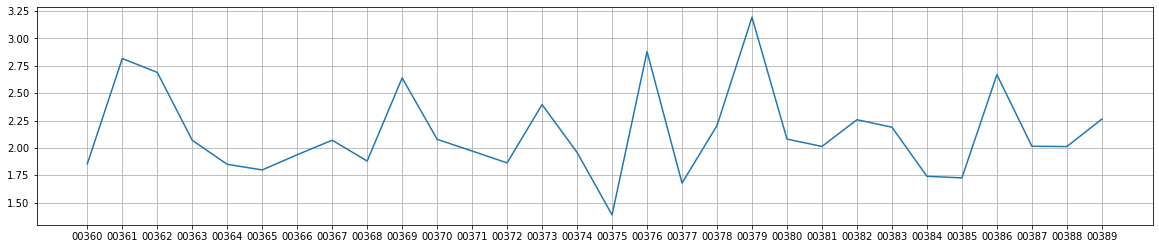

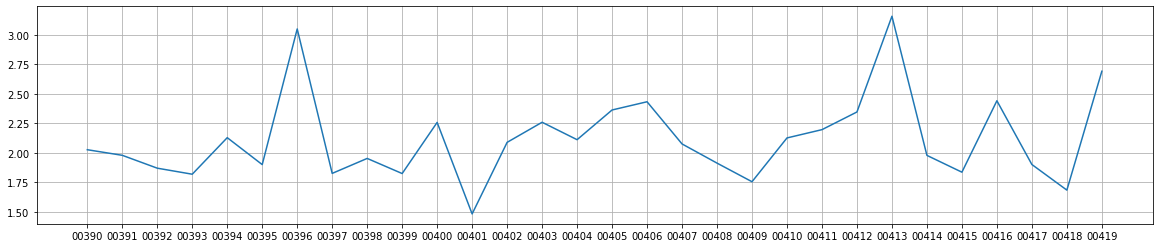

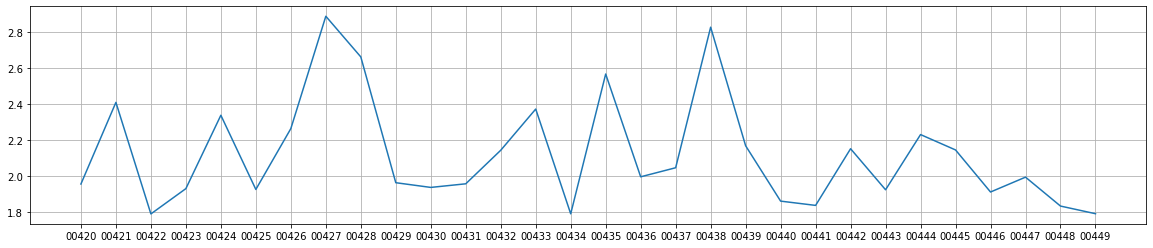

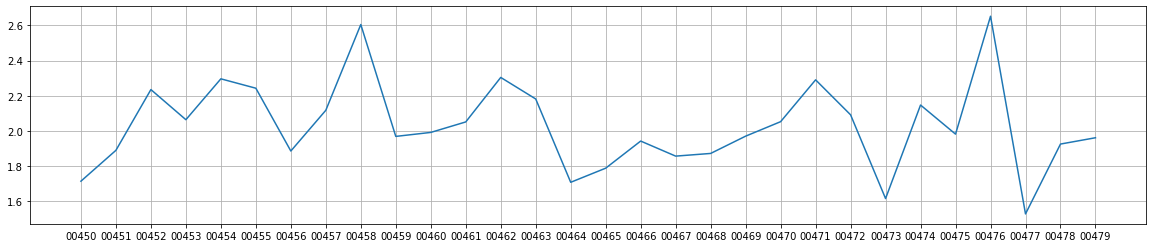

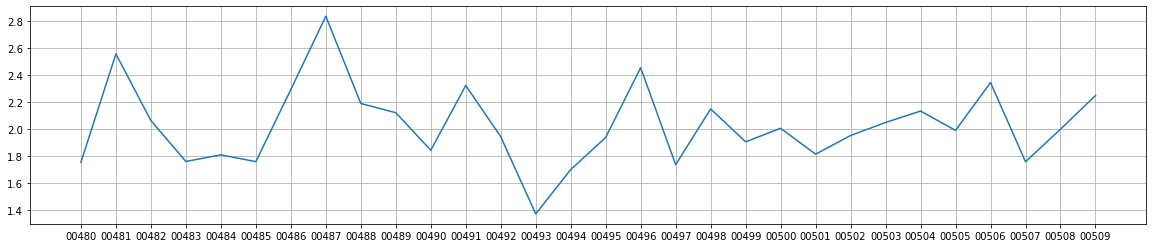

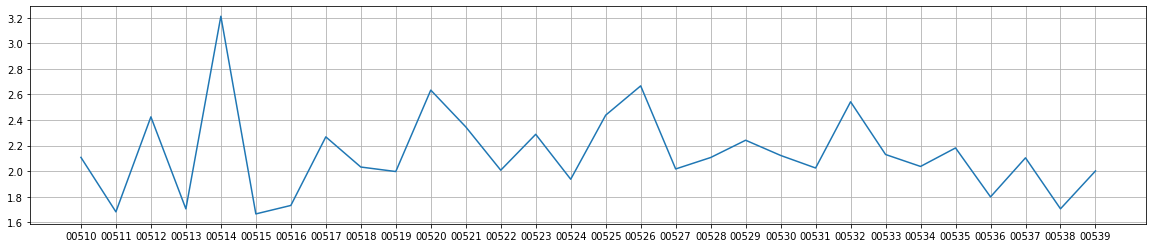

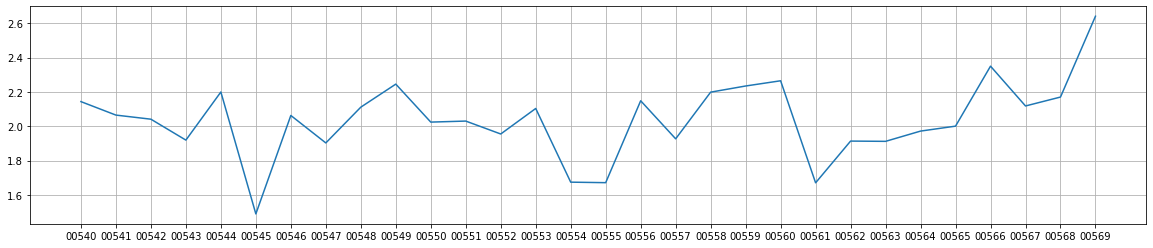

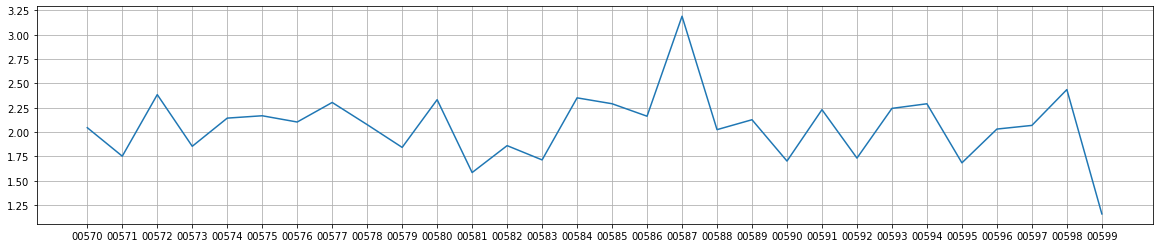

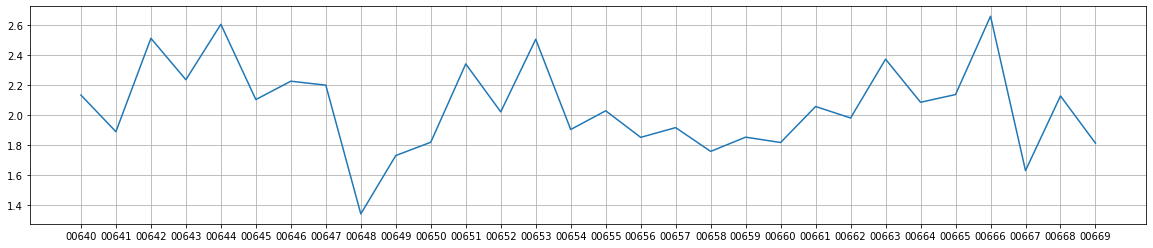

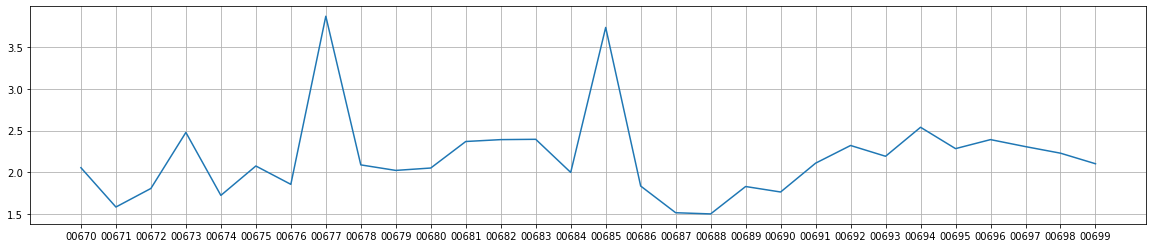

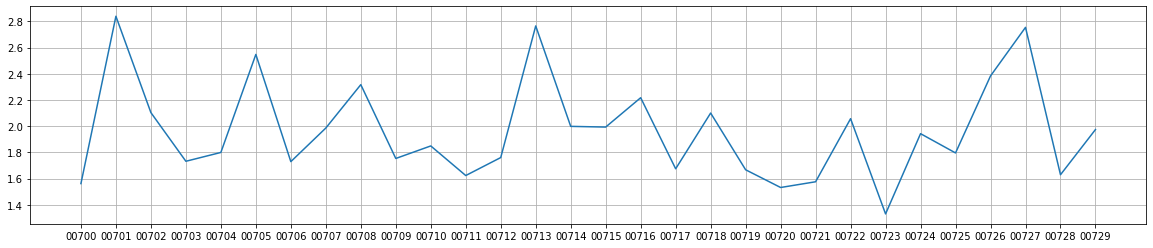

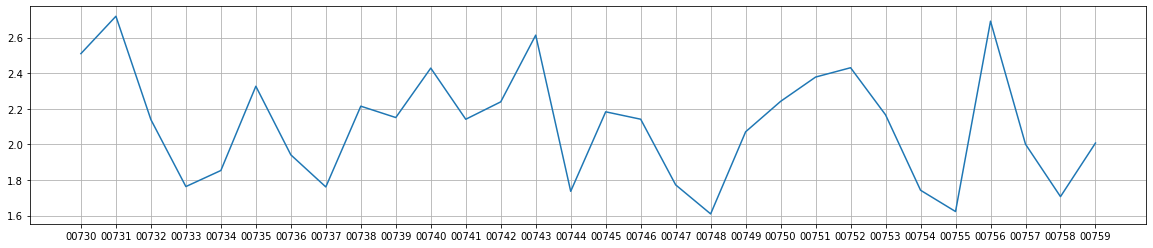

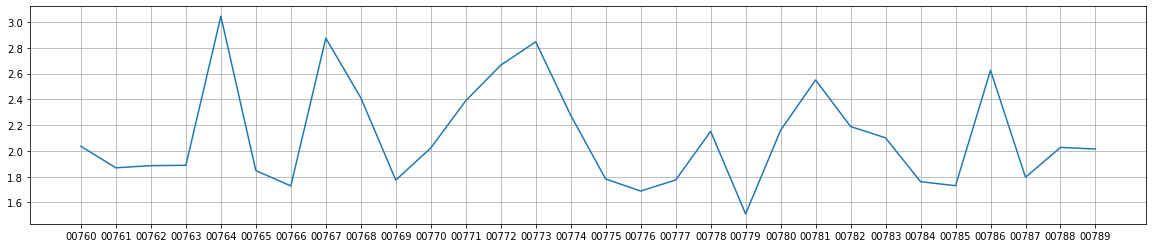

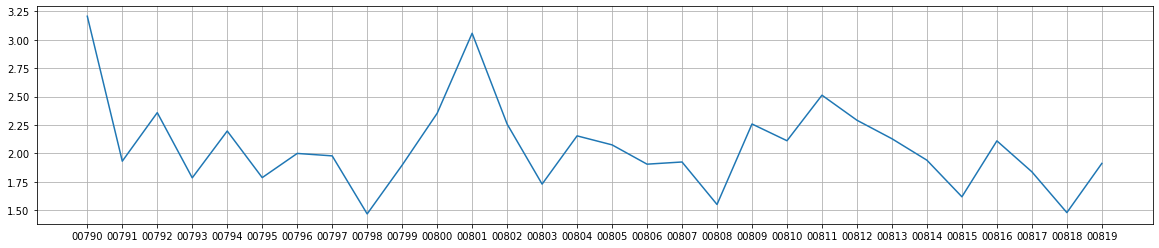

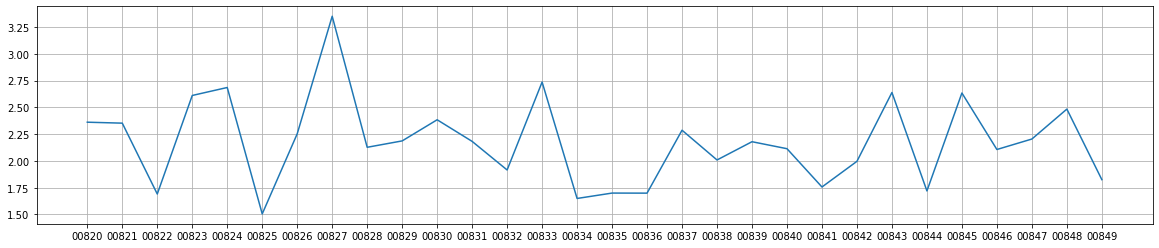

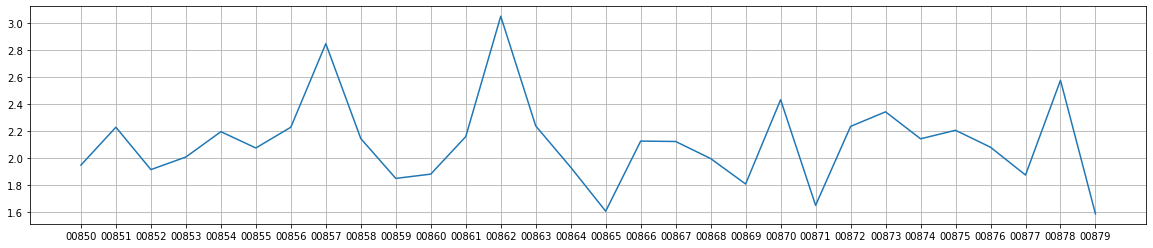

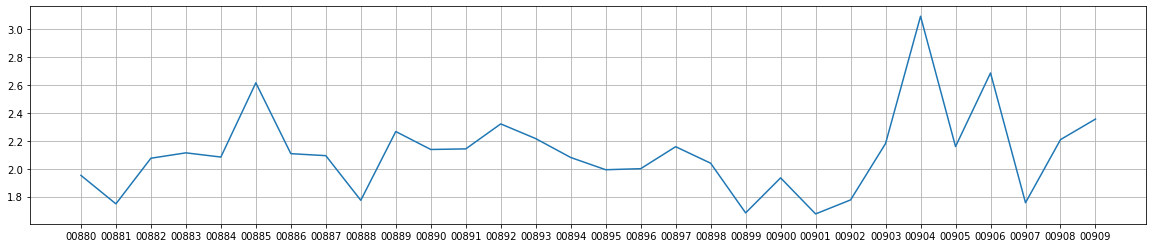

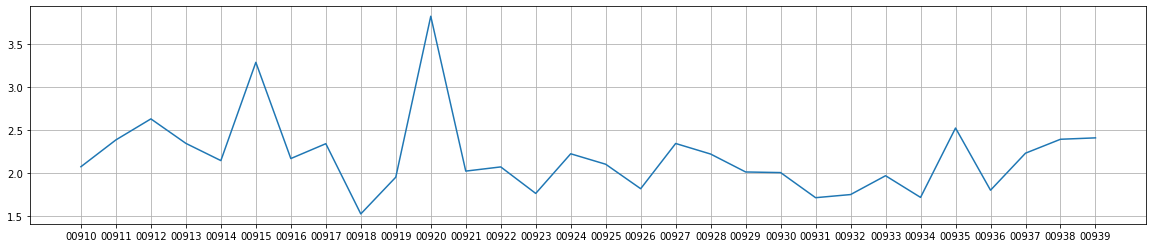

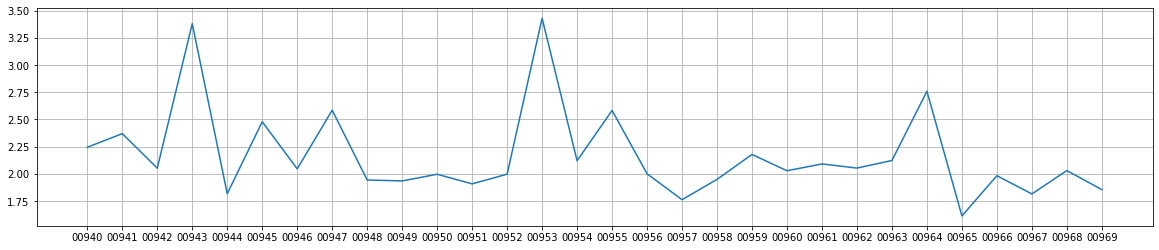

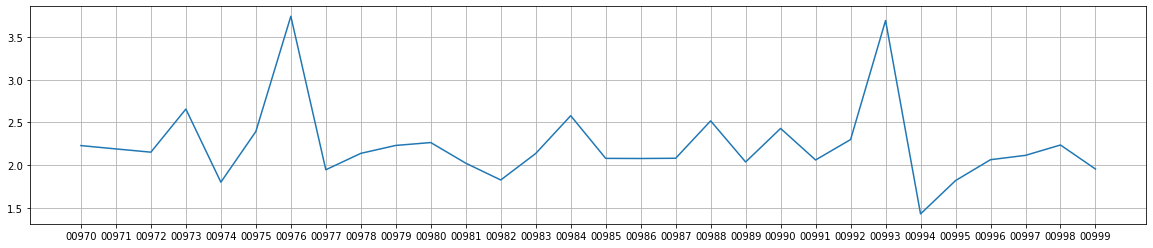

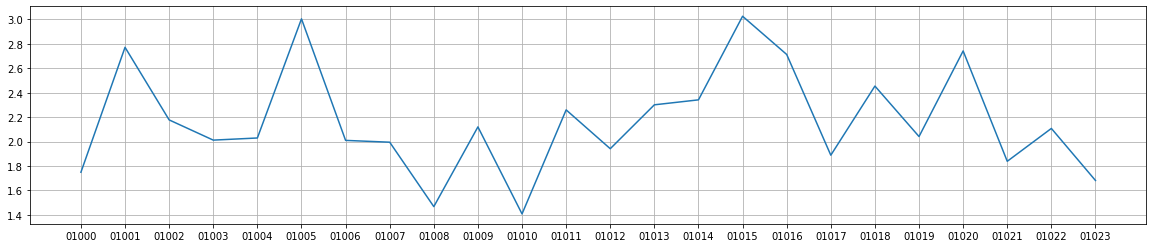

In [12]:
filename_series = []
time_series = []
for file in df['Filename'].unique():
    filename_series.append(os.path.splitext(ntpath.basename(file))[0][6:11])
    time_series.append(profile.GetIOTime(filepath=file))

zipped_lists = zip(filename_series, time_series)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
filename_series, time_series = [ list(tuple) for tuple in  tuples]
points_x = 30
for i in range(math.ceil(float(len(time_series))/points_x)):
    start = i * points_x
    end = (i+1) * points_x
    plt.figure(figsize=(20,4))
    plt.grid()
    plt.plot(filename_series[start:end], time_series[start:end]);
    plt.show()

### I/O Time spent per rank

In [13]:
for rank in df['Rank'].unique():
    print("I/O time for rank {}: {:0.2f} seconds".format(rank,profile.GetIOTime(rank=rank)))

I/O time for rank 0: 185.28 seconds
I/O time for rank 1: 181.48 seconds
I/O time for rank 2: 153.27 seconds
I/O time for rank 3: 166.08 seconds
I/O time for rank 4: 200.00 seconds
I/O time for rank 5: 179.06 seconds
I/O time for rank 6: 199.41 seconds
I/O time for rank 7: 178.27 seconds
I/O time for rank 8: 164.62 seconds
I/O time for rank 9: 170.44 seconds
I/O time for rank 10: 160.92 seconds
I/O time for rank 11: 166.67 seconds
I/O time for rank 12: 160.00 seconds
I/O time for rank 13: 145.36 seconds
I/O time for rank 14: 180.49 seconds
I/O time for rank 15: 167.99 seconds
I/O time for rank 16: 155.95 seconds
I/O time for rank 17: 164.62 seconds
I/O time for rank 18: 182.24 seconds
I/O time for rank 19: 146.41 seconds
I/O time for rank 20: 178.06 seconds
I/O time for rank 21: 158.79 seconds
I/O time for rank 22: 132.89 seconds
I/O time for rank 23: 161.86 seconds
I/O time for rank 24: 167.14 seconds
I/O time for rank 25: 189.70 seconds
I/O time for rank 26: 167.52 seconds
I/O time fo

I/O time for rank 219: 172.07 seconds
I/O time for rank 220: 155.27 seconds
I/O time for rank 221: 155.07 seconds
I/O time for rank 222: 156.10 seconds
I/O time for rank 223: 155.33 seconds
I/O time for rank 224: 162.50 seconds
I/O time for rank 225: 178.35 seconds
I/O time for rank 226: 177.09 seconds
I/O time for rank 227: 150.80 seconds
I/O time for rank 228: 167.91 seconds
I/O time for rank 229: 185.13 seconds
I/O time for rank 230: 189.49 seconds
I/O time for rank 231: 176.96 seconds
I/O time for rank 232: 177.04 seconds
I/O time for rank 233: 188.24 seconds
I/O time for rank 234: 178.04 seconds
I/O time for rank 235: 170.06 seconds
I/O time for rank 236: 179.19 seconds
I/O time for rank 237: 176.99 seconds
I/O time for rank 238: 172.48 seconds
I/O time for rank 239: 161.76 seconds
I/O time for rank 240: 143.04 seconds
I/O time for rank 241: 165.83 seconds
I/O time for rank 242: 157.45 seconds
I/O time for rank 243: 169.97 seconds
I/O time for rank 244: 166.59 seconds
I/O time for

I/O time for rank 435: 166.81 seconds
I/O time for rank 436: 176.41 seconds
I/O time for rank 437: 171.37 seconds
I/O time for rank 438: 179.52 seconds
I/O time for rank 439: 168.76 seconds
I/O time for rank 440: 191.16 seconds
I/O time for rank 441: 173.31 seconds
I/O time for rank 442: 169.52 seconds
I/O time for rank 443: 179.75 seconds
I/O time for rank 444: 189.19 seconds
I/O time for rank 445: 181.07 seconds
I/O time for rank 446: 164.98 seconds
I/O time for rank 447: 155.55 seconds
I/O time for rank 448: 177.66 seconds
I/O time for rank 449: 168.19 seconds
I/O time for rank 450: 164.37 seconds
I/O time for rank 451: 159.44 seconds
I/O time for rank 452: 148.32 seconds
I/O time for rank 453: 151.89 seconds
I/O time for rank 454: 139.20 seconds
I/O time for rank 455: 156.67 seconds
I/O time for rank 456: 186.13 seconds
I/O time for rank 457: 180.12 seconds
I/O time for rank 458: 170.22 seconds
I/O time for rank 459: 168.83 seconds
I/O time for rank 460: 163.30 seconds
I/O time for

In [14]:
"Total I/O performed by application: {:0.2f} GB".format(float(profile.GetIOSize())/1024.0/1024.0/1024.0)

'Total I/O performed by application: 3864.95 GB'

### I/O performed on each file

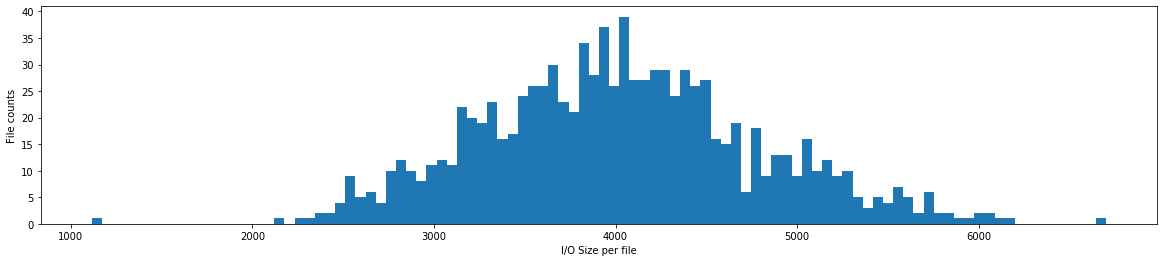

In [15]:
filename_series = []
size_series = []
for file in df['Filename'].unique():
    filename_series.append(os.path.splitext(ntpath.basename(file))[0][6:11])
    size_series.append(float(profile.GetIOSize(filepath=file))/1024.0/1024.0)

zipped_lists = zip(filename_series, size_series)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
filename_series, size_series = [ list(tuple) for tuple in  tuples]



plt.figure(figsize=(20,4))
size_series = np.array(size_series)
plt.hist(size_series,bins = 100)
plt.xlabel("I/O Size per file")
plt.ylabel("File counts")
plt.show()
    
# points_x = 30
# for i in range(math.ceil(float(len(size_series))/points_x)):
#     start = i * points_x
#     end = (i+1) * points_x
#     plt.figure(figsize=(20,4))
#     plt.grid()
#     plt.plot(filename_series[start:end], size_series[start:end]);
#     plt.show()

In [16]:
for rank in df['Rank'].unique():
    print("I/O performed by rank {}: {:0.2f} MB".format(rank, float(profile.GetIOSize(rank=rank))/1024.0/1024.0))

I/O performed by rank 0: 7737.93 MB
I/O performed by rank 1: 7713.40 MB
I/O performed by rank 2: 7669.87 MB
I/O performed by rank 3: 7785.38 MB
I/O performed by rank 4: 7717.23 MB
I/O performed by rank 5: 7778.68 MB
I/O performed by rank 6: 7714.84 MB
I/O performed by rank 7: 7756.16 MB
I/O performed by rank 8: 7780.07 MB
I/O performed by rank 9: 7677.68 MB
I/O performed by rank 10: 7806.07 MB
I/O performed by rank 11: 7700.52 MB
I/O performed by rank 12: 7619.32 MB
I/O performed by rank 13: 7776.24 MB
I/O performed by rank 14: 7715.65 MB
I/O performed by rank 15: 7722.98 MB
I/O performed by rank 16: 7750.33 MB
I/O performed by rank 17: 7761.78 MB
I/O performed by rank 18: 7736.99 MB
I/O performed by rank 19: 7660.84 MB
I/O performed by rank 20: 7688.30 MB
I/O performed by rank 21: 7703.62 MB
I/O performed by rank 22: 7615.31 MB
I/O performed by rank 23: 7699.30 MB
I/O performed by rank 24: 7690.63 MB
I/O performed by rank 25: 7691.75 MB
I/O performed by rank 26: 7771.60 MB
I/O perform

I/O performed by rank 219: 7721.78 MB
I/O performed by rank 220: 7684.34 MB
I/O performed by rank 221: 7657.89 MB
I/O performed by rank 222: 7749.33 MB
I/O performed by rank 223: 7693.46 MB
I/O performed by rank 224: 7734.57 MB
I/O performed by rank 225: 7721.05 MB
I/O performed by rank 226: 7825.04 MB
I/O performed by rank 227: 7757.85 MB
I/O performed by rank 228: 7774.32 MB
I/O performed by rank 229: 7809.17 MB
I/O performed by rank 230: 7796.87 MB
I/O performed by rank 231: 7802.66 MB
I/O performed by rank 232: 7792.63 MB
I/O performed by rank 233: 7691.62 MB
I/O performed by rank 234: 7698.68 MB
I/O performed by rank 235: 7736.93 MB
I/O performed by rank 236: 7872.95 MB
I/O performed by rank 237: 7698.23 MB
I/O performed by rank 238: 7737.39 MB
I/O performed by rank 239: 7689.09 MB
I/O performed by rank 240: 7575.20 MB
I/O performed by rank 241: 7710.33 MB
I/O performed by rank 242: 7680.37 MB
I/O performed by rank 243: 7656.77 MB
I/O performed by rank 244: 7802.68 MB
I/O performe

I/O performed by rank 435: 7786.02 MB
I/O performed by rank 436: 7793.36 MB
I/O performed by rank 437: 7686.56 MB
I/O performed by rank 438: 7716.96 MB
I/O performed by rank 439: 7707.63 MB
I/O performed by rank 440: 7760.80 MB
I/O performed by rank 441: 7755.55 MB
I/O performed by rank 442: 7742.27 MB
I/O performed by rank 443: 7898.43 MB
I/O performed by rank 444: 7720.06 MB
I/O performed by rank 445: 7876.51 MB
I/O performed by rank 446: 7768.67 MB
I/O performed by rank 447: 7682.55 MB
I/O performed by rank 448: 7717.66 MB
I/O performed by rank 449: 7800.55 MB
I/O performed by rank 450: 7698.52 MB
I/O performed by rank 451: 7666.20 MB
I/O performed by rank 452: 7723.43 MB
I/O performed by rank 453: 7682.62 MB
I/O performed by rank 454: 7736.08 MB
I/O performed by rank 455: 7708.26 MB
I/O performed by rank 456: 7736.70 MB
I/O performed by rank 457: 7754.25 MB
I/O performed by rank 458: 7692.06 MB
I/O performed by rank 459: 7816.39 MB
I/O performed by rank 460: 7629.25 MB
I/O performe

In [17]:
print("Average Size of dataset {:0.2f} MB".format(np.mean(list(profile.GetFileSizes().values()))/1024.0/1024.0))

Average Size of dataset 119.26 MB


### How application access data over time.

[============================================================] 100.0% 15885848 of 15885848 Creating Timeline 


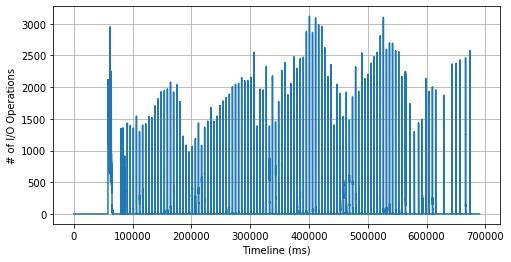

In [18]:
tl = profile.CreateIOTimeline(is_print=False)
plt.figure(figsize=(8,4))
plt.xlabel("Timeline (ms)")
plt.ylabel("# of I/O Operations")
plt.grid()
plt.plot(tl['time_step'], tl['operation_count']);

# plt.figure(figsize=(20,4))
plt.grid()
plt.plot(tl['time_step'], tl['io_bytes']);

### How files are accessed over the duration of the Job.

[============================================================] 100.0% 18434 of 18434 Creating Timeline 
[============================================================] 100.0% 17758 of 17758 Creating Timeline 
[============================================================] 100.0% 19174 of 19174 Creating Timeline 
[============================================================] 100.0% 16246 of 16246 Creating Timeline 
[============================================================] 100.0% 17232 of 17232 Creating Timeline 
[============================================================] 100.0% 12649 of 12649 Creating Timeline 
[============================================================] 100.0% 14808 of 14808 Creating Timeline 
[============================================================] 100.0% 16345 of 16345 Creating Timeline 


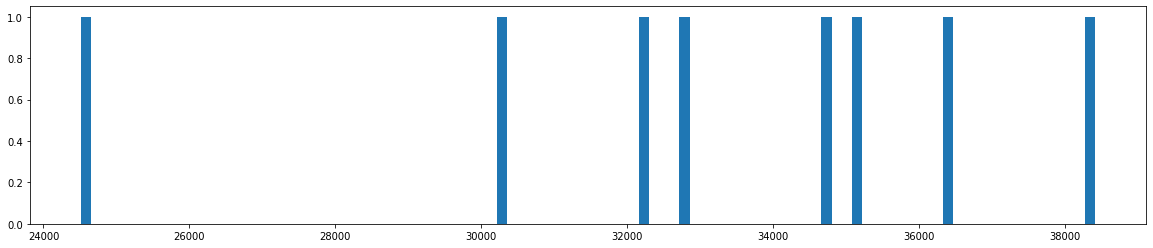

In [19]:
filename_series = []
operation_series = []
for file in df['Filename'].unique()[:8]:
    tl = profile.CreateIOTimeline(filepath=file,is_print=False,save=False)
    filename_series.append(os.path.splitext(ntpath.basename(file))[0][6:11])
    operation_series.append(tl['operation_count'].sum())

plt.figure(figsize=(20,4))
operation_series = np.array(operation_series)
plt.hist(operation_series,bins = 100);
plt.show()

### Show how each file is accessed by each rank.

[============================================================] 100.0% 31078 of 31078 Creating Timeline 
[============================================================] 100.0% 30977 of 30977 Creating Timeline 
[============================================================] 100.0% 30806 of 30806 Creating Timeline 
[============================================================] 100.0% 31268 of 31268 Creating Timeline 
[============================================================] 100.0% 30995 of 30995 Creating Timeline 
[============================================================] 100.0% 31239 of 31239 Creating Timeline 
[============================================================] 100.0% 30983 of 30983 Creating Timeline 
[============================================================] 100.0% 31152 of 31152 Creating Timeline 


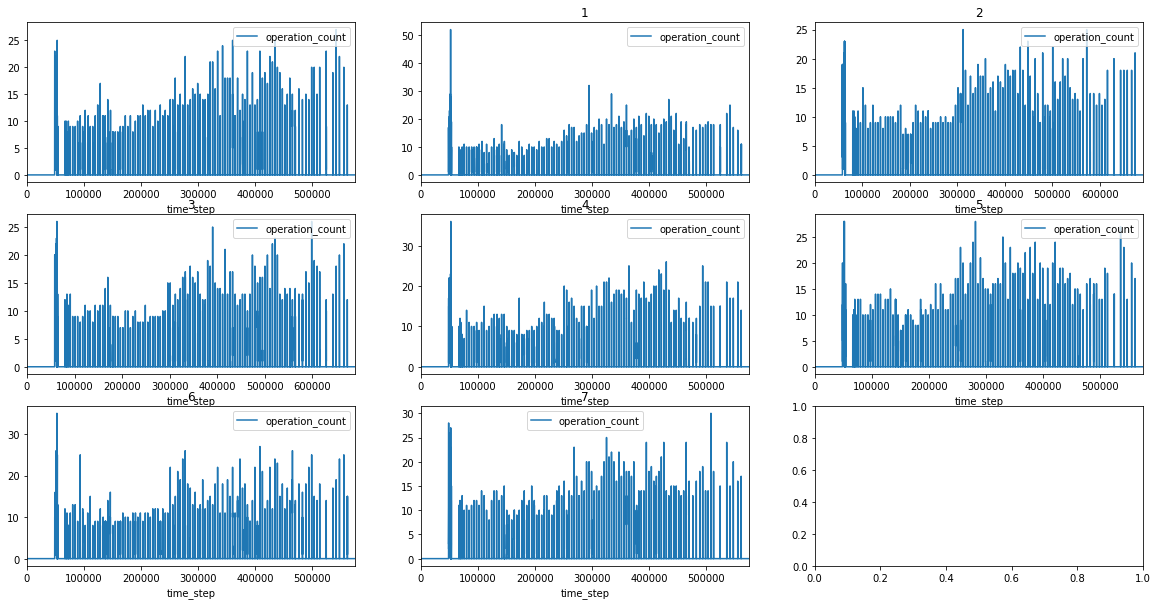

In [27]:
fig, axs = plt.subplots(3, 3, figsize=(20, 10))
for rank in df['Rank'].unique()[:8]:
    x = int(rank/3)
    y = rank%3
    tl = profile.CreateIOTimeline(rank=rank,save=False)
    tl.plot(x='time_step',y='operation_count', title=rank, ax=axs[x][y])
plt.show()

### Data Transfer Size distribution within the application

Text(0.5, 0, 'Transfer Size in bytes')

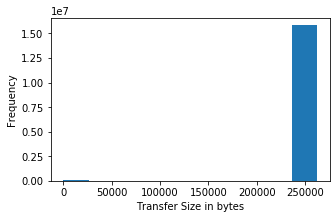

In [21]:
request_df = profile.GetIORequestDistribution()
df['Length'].plot(kind='hist', figsize=(5, 3));
plt.xlabel("Transfer Size in bytes")

### Data Transfer Size distribution for each file.

In [22]:
filename_series = []
request_mean = []
for file in df['Filename'].unique()[:8]:
    tl = profile.GetIORequestDistribution(filepath=file)
    request_mean.append(tl.mean())

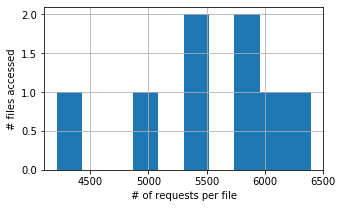

In [23]:
plt.figure(figsize=(5,3))
request_mean = np.array(request_mean)
plt.hist(request_mean,bins = 10);
plt.ylabel("# files accessed")
plt.xlabel("# of requests per file")
plt.grid()
plt.show()

### Data Transfer Sizes per Rank

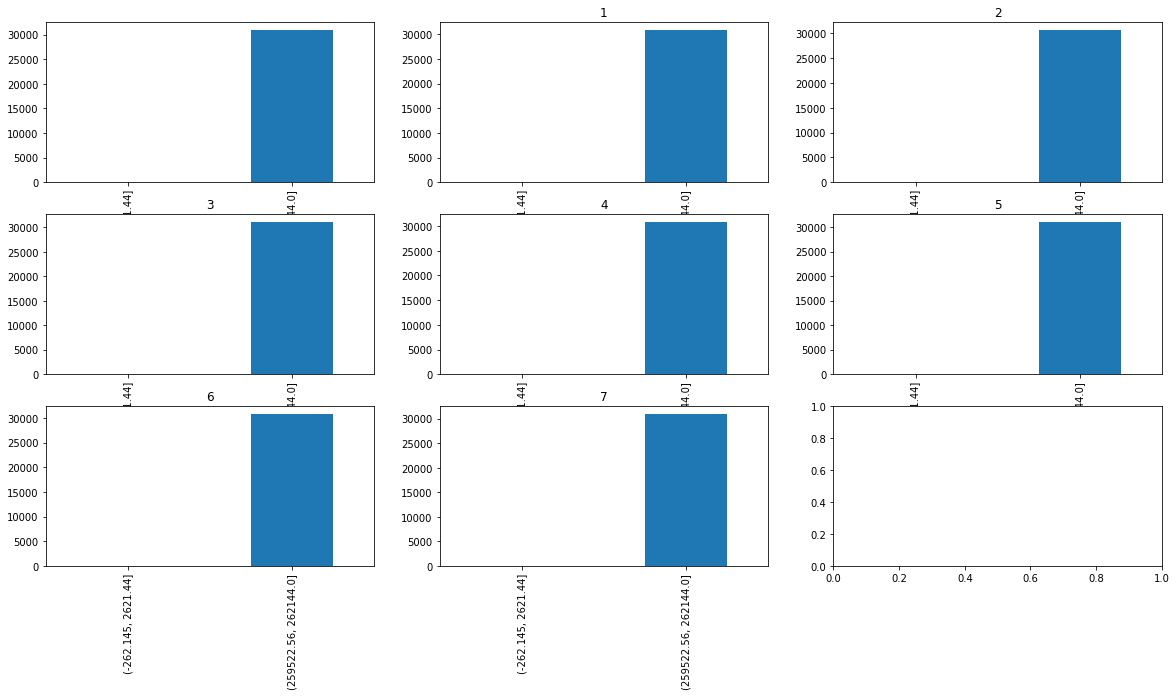

In [24]:
fig, axs = plt.subplots(3, 3, figsize=(20, 10))
for rank in df['Rank'].unique()[:8]:
    x = int(rank/3)
    y = rank%3
    tl = profile.GetIORequestDistribution(rank=rank)
    tl.plot(kind='bar', title=rank, ax=axs[x][y])

### File summary of each file accessed by the Application

In [25]:
pp = pprint.PrettyPrinter(indent=1)
count =1
for file in df['Filename'].unique()[:8]:
    if 'h5' in file:
        pp.pprint(profile.GetFileSummary(file,ext='h5'))
    else:
        if count == 1:
            count+=1
            pp.pprint(profile.GetFileSummary(file,ext='tfrecord',tf_record_features={
      'image/encoded': tf.io.FixedLenFeature((), dtype=tf.string, default_value=''),
      'image/source_id': tf.io.FixedLenFeature((), tf.string, default_value=''),
      'image/height': tf.io.FixedLenFeature((), tf.int64, default_value=1),
      'image/width': tf.io.FixedLenFeature((), tf.int64, default_value=1),
      'image/object/bbox/xmin': tf.io.VarLenFeature(dtype=tf.float32),
      'image/object/bbox/ymin': tf.io.VarLenFeature(dtype=tf.float32),
      'image/object/bbox/xmax': tf.io.VarLenFeature(dtype=tf.float32),
      'image/object/bbox/ymax': tf.io.VarLenFeature(dtype=tf.float32),
      'image/object/class/label': tf.io.VarLenFeature(dtype=tf.int64),
      'image/object/class/text': tf.io.FixedLenFeature((), dtype=tf.string, default_value=''),
      'image/colorspace': tf.io.FixedLenFeature((), tf.string, default_value=''),
      'image/channels': tf.io.FixedLenFeature((), tf.int64, default_value=1),
      'image/format': tf.io.FixedLenFeature((), tf.string, default_value=''),
      'image/filename': tf.io.FixedLenFeature((), tf.string, default_value='')
  }))

{'ext': 'tfrecord',
 'filename': 'train-00073-of-01024',
 'io_size': 4815407506,
 'io_time': 2.363641860464661,
 'path': '/projects/datascience/rzamora/data/imagenet/count.48.size.8m/train-00073-of-01024',
 'size': 143002797,
 'special': <ParallelMapDataset shapes: {image/object/bbox/xmax: (None,), image/object/bbox/xmin: (None,), image/object/bbox/ymax: (None,), image/object/bbox/ymin: (None,), image/object/class/label: (None,), image/channels: (), image/colorspace: (), image/encoded: (), image/filename: (), image/format: (), image/height: (), image/object/class/text: (), image/source_id: (), image/width: ()}, types: {image/object/bbox/xmax: tf.float32, image/object/bbox/xmin: tf.float32, image/object/bbox/ymax: tf.float32, image/object/bbox/ymin: tf.float32, image/object/class/label: tf.int64, image/channels: tf.int64, image/colorspace: tf.string, image/encoded: tf.string, image/filename: tf.string, image/format: tf.string, image/height: tf.int64, image/object/class/text: tf.string, 

In [26]:
profile.CreateChromeTimeline(location="/home/dhari/timeline/apps/imagenet", filename="imagenet_run5_p8.json")

[============================================================] 100.0% 15885848 of 15885848 Creating DXT Timeline 
[============================================================] 100.0% 1216 of 1216 Creating DXT Timeline 


{'traceEvents': [{'name': '/projects/datascience/rzamora/data/imagenet/count.48.size.8m/train-00090-of-01024',
   'cat': 'X_POSIX',
   'ph': 'B',
   'ts': 290520500,
   'pid': 118,
   'tid': 0,
   'args': {'Module': 'X_POSIX',
    'Filename': '/projects/datascience/rzamora/data/imagenet/count.48.size.8m/train-00090-of-01024',
    'Rank': 118,
    'Operation': 'read',
    'Segment': 0,
    'Offset': 0,
    'Length': 262144,
    'Start': 290.5205,
    'End': 290.5434}},
  {'name': '/projects/datascience/rzamora/data/imagenet/count.48.size.8m/train-00351-of-01024',
   'cat': 'X_POSIX',
   'ph': 'B',
   'ts': 290520500,
   'pid': 118,
   'tid': 0,
   'args': {'Module': 'X_POSIX',
    'Filename': '/projects/datascience/rzamora/data/imagenet/count.48.size.8m/train-00351-of-01024',
    'Rank': 118,
    'Operation': 'read',
    'Segment': 0,
    'Offset': 0,
    'Length': 262144,
    'Start': 290.5205,
    'End': 290.5534}},
  {'name': '/projects/datascience/rzamora/data/imagenet/count.48.size